In [1]:
import pandas as pd
import numpy as np
from numpy import arange
import os
from collections import defaultdict
import matplotlib.pyplot as plt
from itertools import chain
import statsmodels.api as sm
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_validate
from json import dump, load

In [3]:
POI_COUNTS_DIRECTORY = '../data/curated/poi_counts.json'
POI_TYPES_DIRECTORY = "../data/curated/poi_types.txt"
RENTAL_DIRECTORY = '../data/curated/rental_properties_cleaned.csv'

In [4]:
with open(POI_COUNTS_DIRECTORY, 'r') as f:
        count_data = load(f)

In [5]:
# Code to read back category types if needed
with open(POI_TYPES_DIRECTORY, 'r') as fp:
    ls = fp.read().splitlines()

In [6]:
len(count_data)

5978

In [7]:
len(ls)

270

In [8]:
df = pd.DataFrame.from_dict(count_data, orient='index', columns=ls)

In [9]:
df.reset_index(inplace=True)

In [10]:
df.fillna(0, inplace=True)

In [43]:
df

,index,pitch,water,school,swimming_pool,parking,social_facility,fuel,mall,hardware,...,milestone,volcano,garden_furniture,swimming_area,heliport,summer_camp,brewing_supplies,perfumery,pillory,fort
0,"[-36.253557, 144.944557]",12.0,16.0,2.0,8.0,6.0,4.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"[-36.554159, 146.7208003]",47.0,23.0,3.0,19.0,16.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"[-36.5530096, 146.7188613]",47.0,21.0,3.0,18.0,16.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"[-36.5380049, 145.9927626]",7.0,9.0,3.0,1.0,21.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"[-36.5424309, 145.9979175]",5.0,15.0,3.0,1.0,21.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5973,"[-37.8802849, 147.8299957]",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5974,"[-37.8791032, 147.8273685]",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5975,"[-38.1336473, 144.7061689]",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5976,"[-38.372703, 144.7856897]",0.0,0.0,0.0,0.0,8.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
rental_data = pd.read_csv(RENTAL_DIRECTORY)

In [14]:
cost_data = rental_data[['coordinates', 'cost_text']]
df = pd.concat([df, cost_data], join='inner', ignore_index=True, axis=1).drop(columns=[271])

In [15]:
df

,0,1,2,3,4,5,6,7,8,9,...,262,263,264,265,266,267,268,269,270,272
0,"[-36.253557, 144.944557]",12.0,16.0,2.0,8.0,6.0,4.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.000000
1,"[-36.554159, 146.7208003]",47.0,23.0,3.0,19.0,16.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.923077
2,"[-36.5530096, 146.7188613]",47.0,21.0,3.0,18.0,16.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.384615
3,"[-36.5380049, 145.9927626]",7.0,9.0,3.0,1.0,21.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.000000
4,"[-36.5424309, 145.9979175]",5.0,15.0,3.0,1.0,21.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5973,"[-37.8802849, 147.8299957]",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,720.000000
5974,"[-37.8791032, 147.8273685]",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,720.000000
5975,"[-38.1336473, 144.7061689]",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,725.000000
5976,"[-38.372703, 144.7856897]",0.0,0.0,0.0,0.0,8.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,725.000000


In [16]:
columns = [['coordinates'], ls, ['cost']]
columns = list(chain.from_iterable(columns))

In [17]:
columns

['coordinates',
 'pitch',
 'water',
 'school',
 'swimming_pool',
 'parking',
 'social_facility',
 'fuel',
 'mall',
 'hardware',
 'police',
 'post_office',
 'pharmacy',
 'beauty',
 'dairy',
 'golf_course',
 'park',
 'hospital',
 'sports_centre',
 'community_centre',
 'caravan_site',
 'kindergarten',
 'place_of_worship',
 'raceway',
 'restaurant',
 'tyres',
 'veterinary',
 'building',
 'alcohol',
 'supermarket',
 'nursing_home',
 'pub',
 'courthouse',
 'fire_station',
 'playground',
 'bicycle',
 'garden',
 'motel',
 'information',
 'library',
 'viewpoint',
 'picnic_site',
 'bbq',
 'bank',
 'museum',
 'peak',
 'memorial',
 'variety_store',
 'monument',
 'bakery',
 'car_wash',
 'artwork',
 'townhall',
 'fast_food',
 'cafe',
 'doityourself',
 'bar',
 'picnic_table',
 'agrarian',
 'laundry',
 'bicycle_parking',
 'sports',
 'fitness_centre',
 'motorcycle',
 'antiques',
 'dentist',
 'florist',
 'clothes',
 'butcher',
 'newsagent',
 'furniture',
 'platform',
 'station',
 'gallery',
 'aerodrome'

In [18]:
df = df.set_axis(columns, axis=1)

In [19]:
df

,coordinates,pitch,water,school,swimming_pool,parking,social_facility,fuel,mall,hardware,...,volcano,garden_furniture,swimming_area,heliport,summer_camp,brewing_supplies,perfumery,pillory,fort,cost
0,"[-36.253557, 144.944557]",12.0,16.0,2.0,8.0,6.0,4.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.000000
1,"[-36.554159, 146.7208003]",47.0,23.0,3.0,19.0,16.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.923077
2,"[-36.5530096, 146.7188613]",47.0,21.0,3.0,18.0,16.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.384615
3,"[-36.5380049, 145.9927626]",7.0,9.0,3.0,1.0,21.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.000000
4,"[-36.5424309, 145.9979175]",5.0,15.0,3.0,1.0,21.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5973,"[-37.8802849, 147.8299957]",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,720.000000
5974,"[-37.8791032, 147.8273685]",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,720.000000
5975,"[-38.1336473, 144.7061689]",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,725.000000
5976,"[-38.372703, 144.7856897]",0.0,0.0,0.0,0.0,8.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,725.000000


In [20]:
# Save POI data in csv format
df.to_csv('../data/curated/poi_counts.csv')

## Analysis

In [20]:
X, y = df.iloc[:,1:-1], df.iloc[:,-1]
model = ElasticNet()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1)
# define grid
grid = dict()
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid['l1_ratio'] = arange(0, 1, 0.1)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=2)
# perform the search
results = search.fit(X, y)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: -81.752
Config: {'alpha': 0.1, 'l1_ratio': 0.0}


c:\Users\aranw\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.165e+07, tolerance: 7.635e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


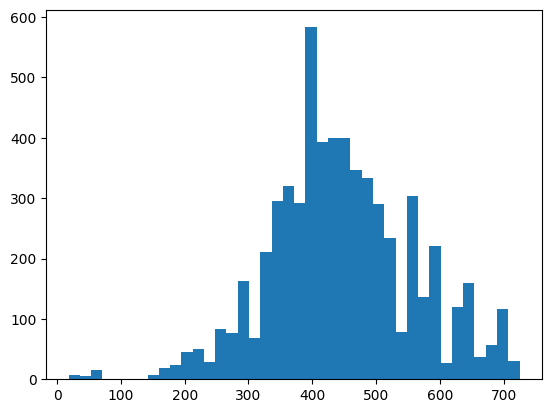

In [21]:
plt.hist(df['cost'], bins = 40)
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x1981401c970>,
 'caps': [<matplotlib.lines.Line2D at 0x1981401cd90>,
 'boxes': [<matplotlib.lines.Line2D at 0x1981401c6d0>],
 'medians': [<matplotlib.lines.Line2D at 0x1981401d2d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1981401d570>],
 'means': []}

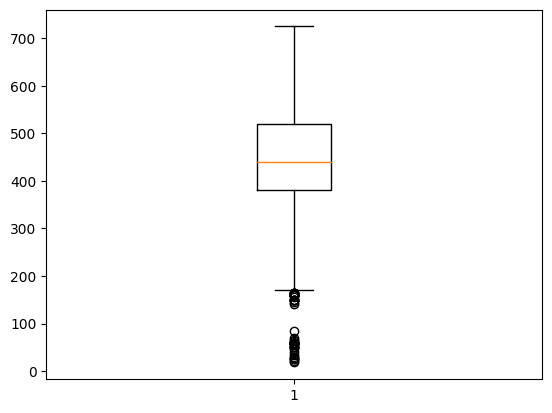

In [22]:
plt.boxplot(df['cost'])

In [20]:
def get_stats():
    x = df[ls]
    y = df['cost']
    results = sm.OLS(y, x).fit()
    print(results.summary())

In [21]:
get_stats()

                                 OLS Regression Results                                
Dep. Variable:                   cost   R-squared (uncentered):                   0.825
Model:                            OLS   Adj. R-squared (uncentered):              0.817
Method:                 Least Squares   F-statistic:                              99.96
Date:                Tue, 27 Sep 2022   Prob (F-statistic):                        0.00
Time:                        12:39:19   Log-Likelihood:                         -39924.
No. Observations:                5978   AIC:                                  8.039e+04
Df Residuals:                    5708   BIC:                                  8.220e+04
Df Model:                         270                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

In [53]:
x = df[ls]
y = df['cost']

In [54]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(x)

In [55]:
df_scaled

array([[-0.73758837,  0.45977085, -0.94491887, ..., -0.01293476,
        -0.01293476, -0.01293476],
       [-0.29364047,  1.02495903, -0.84917939, ..., -0.01293476,
        -0.01293476, -0.01293476],
       [-0.29364047,  0.86347669, -0.84917939, ..., -0.01293476,
        -0.01293476, -0.01293476],
       ...,
       [-0.88979908, -0.83208785, -1.13639782, ..., -0.01293476,
        -0.01293476, -0.01293476],
       [-0.88979908, -0.83208785, -1.13639782, ..., -0.01293476,
        -0.01293476, -0.01293476],
       [-0.88979908, -0.83208785, -1.13639782, ..., -0.01293476,
        -0.01293476, -0.01293476]])

In [63]:
net = ElasticNet(random_state=0, alpha=0.1, l1_ratio=0)
cross_validate(net, df_scaled, y, cv=10, n_jobs=2, scoring='r2')
#net.fit(df_scaled,y)

{'fit_time': array([1.28376889, 1.30624437, 1.19791317, 1.21744847, 1.16977572,
        1.18344903, 1.18525743, 1.1996634 , 1.17559171, 1.19343591]),
 'score_time': array([0.00097752, 0.00097609, 0.00097418, 0.00097632, 0.00097227,
        0.        , 0.00098944, 0.00097442, 0.00097632, 0.000983  ]),
 'test_score': array([-11.37857251, -64.690108  , -68.86075316, -97.15925732,
        -59.61938552, -55.7494883 , -22.03628535, -29.94174029,
        -40.55620691, -39.34240363])}

In [27]:
coefs = net.coef_
remove_list = []
for i in range(len(coefs)):
    if abs(coefs[i]) < 0.05:
        remove_list.append(ls[i])

In [28]:
remove_list

['bar', 'erotic', 'radiotechnics']

In [29]:
len(remove_list)

3

In [30]:
columns = list(chain.from_iterable([['coordinates'],ls]))

In [31]:
df_reduce = df[columns].drop(remove_list, axis=1)

In [32]:
df_reduce.nunique()

coordinates         5978
pitch                369
water                 90
school                75
swimming_pool        318
                    ... 
summer_camp            2
brewing_supplies       2
perfumery              2
pillory                2
fort                   2
Length: 268, dtype: int64

In [38]:
df_reduce.to_csv('../data/curated/reduced_POI.csv')